# 第1题

In [116]:
import numpy as np
from scipy.optimize import minimize_scalar

# 定义目标函数
def f(x):
    x1, x2 = x
    return (x1**4)/4 + (x2**2)/2 - x1*x2 + x1 - x2

# 定义梯度
def grad_f(x):
    x1, x2 = x
    df_dx1 = x1**3 - x2 + 1
    df_dx2 = x2 - x1 - 1
    return np.array([df_dx1, df_dx2])

# 线搜索函数
def line_search(f, xk, dk):
    phi = lambda alpha: f(xk + alpha * dk)
    res = minimize_scalar(phi, bounds=(0,5), method='bounded', options={'xatol': 1e-6})
    return res.x

In [117]:
# DFP主程序
def DFP(f, grad_f, x0, tol=1e-6, max_iter=1000):
    xk = np.array(x0, dtype=float)
    Hk = np.eye(len(x0))
    hist = []
    for k in range(max_iter):
        gk = grad_f(xk)
        norm_gk = np.linalg.norm(gk)
        if norm_gk < tol:
            hist.append((k, xk.copy(), f(xk), gk.copy(), norm_gk, None))
            break
        
        dk = -Hk @ gk
        alpha = line_search(f, xk, dk)
        xk_new = xk + alpha * dk
        gk_new = grad_f(xk_new)
        
        delta_x = xk_new - xk
        delta_g = gk_new - gk
        
        # 更新 Hk
        Hk = Hk + np.outer(delta_x, delta_x) / delta_x.dot(delta_g) \
               - (Hk @ np.outer(delta_g, delta_g) @ Hk) / (delta_g @ Hk @ delta_g)
        
        hist.append((k, xk.copy(), f(xk), gk.copy(), norm_gk, alpha))
        
        xk = xk_new
    
    return hist

In [118]:
# 打印输出
def print_hist(hist):
    print(f"{'k':<3} {'x1':>10} {'x2':>10} {'f(x)':>12} {'||grad||':>12} {'alpha':>10}")
    for k, x, fx, g, normg, alpha in hist:
        alpha_str = f"{alpha:.6f}" if alpha is not None else "-"
        print(f"{k:<3} {x[0]:>10.6f} {x[1]:>10.6f} {fx:>12.6f} {normg:>12.6f} {alpha_str:>10}")

# 测试两个初始点
print("初始点 (0,0)^T：")
hist1 = DFP(f, grad_f, [0,0])
print_hist(hist1)

print("\n初始点 (1.5,1.0)^T：")
hist2 = DFP(f, grad_f, [1.5,1.0])
print_hist(hist2)

初始点 (0,0)^T：
k           x1         x2         f(x)     ||grad||      alpha
0     0.000000   0.000000     0.000000     1.414214   0.596072
1    -0.596072   0.596072    -0.627631     0.271732   1.586866
2    -0.946621   0.358522    -0.700745     0.368605   2.422839
3    -1.050298  -0.007492    -0.746425     0.157065   0.644399
4    -0.999043   0.003383    -0.749996     0.002480   0.999313
5    -0.999946   0.000014    -0.750000     0.000152   1.059407
6    -1.000000  -0.000000    -0.750000     0.000000          -

初始点 (1.5,1.0)^T：
k           x1         x2         f(x)     ||grad||      alpha
0     1.500000   1.000000     0.765625     3.693322   0.254111
1     0.642375   1.381167    -0.629639     0.285845   2.235703
2     0.855450   1.981643    -0.724054     0.377354   1.747929
3     1.012417   2.078697    -0.747647     0.077927   1.070668
4     0.997143   1.998481    -0.749991     0.007154   0.834262
5     0.999995   1.999972    -0.750000     0.000025   1.001478
6     1.000000   2.00000

# 第2题

## 初始化

In [119]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体（适用于中文）
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
plt.style.use('fivethirtyeight')  # 设置绘图风格
np.random.seed(0)

# 定义目标函数及梯度
def f(x):
    x1, x2, x3 = x
    return (3 - x1)**2 + 7*(x2 - x1**2)**2 + 9*(x3 - x1 - x2**2)**2

def grad(x):
    x1, x2, x3 = x
    # 对应偏导数
    df_dx1 = -2*(3 - x1) - 28*x1*(x2 - x1**2) - 18*(x3 - x1 - x2**2)
    df_dx2 = 14*(x2 - x1**2) - 36*x2*(x3 - x1 - x2**2)
    df_dx3 = 18*(x3 - x1 - x2**2)
    return np.array([df_dx1, df_dx2, df_dx3])

# 精确线搜索（黄金分割）
def golden_search(phi, a=0, b=1, tol=1e-6):
    gr = (np.sqrt(5) + 1) / 2
    c = b - (b - a) / gr
    d = a + (b - a) / gr
    while abs(b - a) > tol:
        if phi(c) > phi(d):
            a = c
        else:
            b = d
        c = b - (b - a) / gr
        d = a + (b - a) / gr
    return (a + b) / 2


## 算法

In [120]:
def dfp(x0, max_iter=100, tol=1e-6):
    n = len(x0)
    x = x0.copy()
    H = np.eye(n)
    residuals = []
    H_pd = []
    for k in range(max_iter):
        g = grad(x)
        norm_g = np.linalg.norm(g)
        residuals.append(norm_g)
        # 检查 H 是否正定
        eigs = np.linalg.eigvals(H)
        H_pd.append(np.all(eigs > 0))
        if norm_g < tol:
            break
        d = -H.dot(g)
        phi = lambda alpha: f(x + alpha * d)
        alpha = golden_search(phi)
        s = alpha * d # delta x
        x_new = x + s
        y = grad(x_new) - g # delta g
        Hy = H.dot(y)
        if abs(s.dot(y)) > 1e-12 and abs(y.dot(Hy)) > 1e-12:
            H = H + np.outer(s, s) / (s.dot(y)) - np.outer(Hy, Hy) / (y.dot(Hy))
        x = x_new
    return x, residuals, H_pd

In [121]:
def bfgs(x0, max_iter=100, tol=1e-6):
    n = len(x0)
    x = x0.copy()
    H = np.eye(n)
    residuals = []
    H_pd = []
    for k in range(max_iter):
        g = grad(x)
        norm_g = np.linalg.norm(g)
        residuals.append(norm_g)
        eigs = np.linalg.eigvals(H)
        # 检查 H 是否正定
        H_pd.append(np.all(eigs > 0))
        if norm_g < tol:
            break
        d = -H.dot(g)
        phi = lambda alpha: f(x + alpha * d)
        alpha = golden_search(phi)
        s = alpha * d # delta x
        x_new = x + s
        y = grad(x_new) - g # delta g
        if abs(y.dot(s)) > 1e-12:
            # I = np.eye(n)
            H = H + (1 + y.dot(H).dot(y) / (y.dot(s))) * np.outer(s, s) / (s.dot(y)) - \
                (np.outer(H.dot(y), s) + np.outer(s, H.dot(y))) / (s.dot(y))
        x = x_new
    return x, residuals, H_pd


## 求解

DFP 每步 H 是否正定: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
BFGS 每步 H 是否正定: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

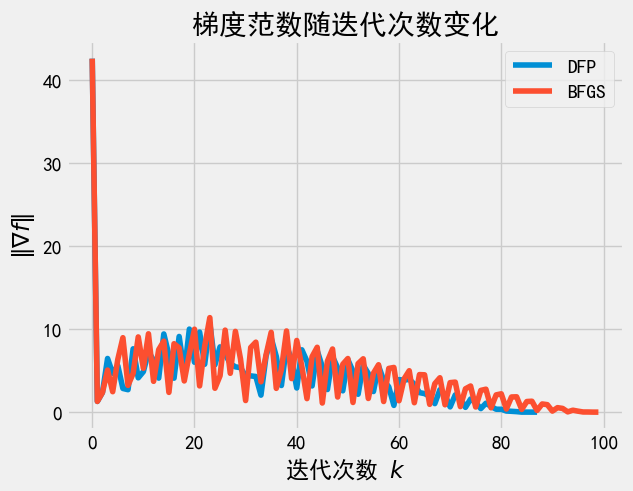

In [122]:
x0 = np.array([1.0, 1.0, 1.0])
x_dfp, res_dfp, pd_dfp = dfp(x0)
x_bfgs, res_bfgs, pd_bfgs = bfgs(x0)

# 打印 H 正定性
print('DFP 每步 H 是否正定:', pd_dfp)
print('BFGS 每步 H 是否正定:', pd_bfgs)

# 绘制梯度范数随迭代次数变化
plt.figure()
plt.plot(res_dfp, label='DFP')
plt.plot(res_bfgs, label='BFGS')
plt.xlabel(r'迭代次数 $k$')
plt.ylabel(r'$\|\nabla f\|$')
plt.title('梯度范数随迭代次数变化')
plt.legend()
plt.show()

# 第3题

## 初始化

In [123]:
import time
def extended_rosenbrock(x, alpha=100.0):
    """
    扩展 Rosenbrock 函数: f(x) = sum_{i=1}^{n/2} [ alpha*( x_{2i} - x_{2i-1}^2 )^2 + (1 - x_{2i-1})^2 ].
    参数:
        x: (n, ) numpy 数组，n 为偶数
        alpha: Rosenbrock 中的 alpha 参数
    返回:
        f(x) 的标量值
    """
    n = len(x)
    assert n % 2 == 0, "n必须是偶数"
    f_val = 0.0
    for i in range(0, n, 2):
        term1 = x[i+1] - x[i]**2
        term2 = 1 - x[i]
        f_val += alpha * (term1**2) + (term2**2)
    return f_val

def grad_extended_rosenbrock(x, alpha=100.0):
    """
    扩展 Rosenbrock 函数的梯度向量
    """
    n = len(x)
    grad = np.zeros_like(x)
    for i in range(0, n, 2):
        # x_{2i-1} -> x[i], x_{2i} -> x[i+1]
        term1 = x[i+1] - x[i]**2
        term2 = 1 - x[i]
        grad[i]   = -4 * alpha * x[i] * term1 - 2 * term2
        grad[i+1] =  2 * alpha * term1
    return grad

In [124]:
def line_search_wolfe(fun, grad, x, p, f0, g0_dot_p, alpha0=1.0, c1=1e-4, c2=0.9, max_iter=20):
    """
      1) f(x+alpha*p) <= f0 + c1*alpha*g0_dot_p
      2) grad(x+alpha*p)' p >= c2 * g0_dot_p
    """
    def zoom(alpha_lo, alpha_hi, f_lo, g_lo_dot_p):
        for _ in range(max_iter):
            alpha = (alpha_lo + alpha_hi) / 2
            x_new = x + alpha * p
            f_new = fun(x_new)
            if f_new > f0 + c1 * alpha * g0_dot_p or f_new >= f_lo:
                alpha_hi = alpha
            else:
                g_new_dot_p = np.dot(grad(x_new), p)
                if g_new_dot_p >= c2 * g0_dot_p:
                    return alpha, f_new, g_new_dot_p
                if g_new_dot_p * (alpha_hi - alpha_lo) >= 0:
                    alpha_hi = alpha_lo
                alpha_lo, f_lo = alpha, f_new
        return alpha_lo, fun(x + alpha_lo * p), np.dot(grad(x + alpha_lo * p), p)

    alpha_prev = 0
    f_prev = f0
    alpha = alpha0
    for i in range(max_iter):
        x_new = x + alpha * p
        f_new = fun(x_new)
        g_new_dot_p = np.dot(grad(x_new), p)
        # Armijo condition or failure to decrease
        if f_new > f0 + c1 * alpha * g0_dot_p or (i > 0 and f_new >= f_prev):
            return zoom(alpha_prev, alpha, f_prev, np.dot(grad(x + alpha_prev * p), p))
        # Curvature condition
        if g_new_dot_p >= c2 * g0_dot_p:
            return alpha, f_new, g_new_dot_p
        # If gradient has reversed sign
        if g_new_dot_p >= 0:
            return zoom(alpha, alpha_prev, f_new, g_new_dot_p)
        alpha_prev, f_prev = alpha, f_new
        alpha *= 2
    return alpha, f_new, g_new_dot_p

In [125]:
def lbfgs(
    fun,
    grad,
    x0,
    m=10,
    tol=1e-6,
    max_iter=1000,
    alpha0=1.0,
    c1=1e-4,
    c2=0.9
):
    """
    Limited-memory BFGS with weak Wolfe line search.
    """
    x = x0.copy()
    s_list, y_list, rho_list = [], [], []
    f_val = fun(x)
    g = grad(x)

    history = {'f_vals': [f_val], 'grad_norms': [np.linalg.norm(g)]}
    k = 0
    start_time = time.time()

    while np.linalg.norm(g) > tol and k < max_iter:
        # Two-loop recursion
        q = g.copy()
        alpha_list = []
        for s, y, rho in zip(reversed(s_list), reversed(y_list), reversed(rho_list)):
            alpha_i = rho * np.dot(s, q)
            alpha_list.append(alpha_i)
            q -= alpha_i * y
        if s_list:
            last_s, last_y = s_list[-1], y_list[-1]
            gamma = np.dot(last_s, last_y) / np.dot(last_y, last_y)
        else:
            gamma = 1.0
        r = gamma * q
        for s, y, rho, alpha_i in zip(s_list, y_list, rho_list, reversed(alpha_list)):
            beta = rho * np.dot(y, r)
            r += s * (alpha_i - beta)
        p = -r

        # Line search satisfying weak Wolfe conditions
        g0_dot_p = np.dot(g, p)
        alpha, f_new, _ = line_search_wolfe(fun, grad, x, p, f_val, g0_dot_p, alpha0, c1, c2)
        x_new = x + alpha * p
        g_new = grad(x_new)

        # Update memory
        s = x_new - x
        y = g_new - g
        if np.dot(s, y) > 1e-10:
            rho = 1.0 / np.dot(y, s)
            if len(s_list) == m:
                s_list.pop(0); y_list.pop(0); rho_list.pop(0)
            s_list.append(s); y_list.append(y); rho_list.append(rho)

        x, f_val, g = x_new, f_new, g_new
        k += 1
        history['f_vals'].append(f_val)
        history['grad_norms'].append(np.linalg.norm(g))

    history['time'] = time.time() - start_time
    history['iterations'] = k
    return x, f_val, k, history

In [126]:
n = 2000
x0 = -np.ones(n)
for m in [1, 3, 5, 10, 20, 30]:
    x_sol, f_sol, iters, hist = lbfgs(
        fun=lambda x: extended_rosenbrock(x, alpha=100),
        grad=lambda x: grad_extended_rosenbrock(x, alpha=100),
        x0=x0,
        m=m
    )
    print(f"m={m:2d} | iter: {iters:4d} | f: {f_sol:.2e} | time: {hist['time']:.2f}s")


m= 1 | iter:   70 | f: 3.87e-15 | time: 0.19s
m= 3 | iter:   27 | f: 9.04e-17 | time: 0.06s
m= 5 | iter:   26 | f: 2.51e-20 | time: 0.06s
m=10 | iter:   25 | f: 1.92e-16 | time: 0.06s
m=20 | iter:   25 | f: 8.55e-17 | time: 0.06s
m=30 | iter:   25 | f: 8.55e-17 | time: 0.06s


# 第4题

In [127]:
import numpy as np
from numpy.linalg import norm, solve

# Soft-thresholding operator
def soft_threshold(u, tau):
    return np.sign(u) * np.maximum(np.abs(u) - tau, 0)

# Method 1: Lipschitz gradient majorant
def Lipschitz(A, b, lambd, L, x0, max_iter=10000):
    x = x0.copy()
    xs = []
    history = []
    for k in range(max_iter):
        grad = A.T @ (A @ x - b)
        x = soft_threshold(x - grad / L, lambd / L)
        xs.append(x)
        obj = 0.5 * norm(A @ x - b)**2 + lambd * norm(x, 1)
        history.append(obj)
    return xs, history

In [128]:
# Method 2: Variational majorant function
def Variational(A, b, lambd, x0, epsilon=1e-6, max_iter=10000):
    x = x0.copy()
    history = []
    xs = []
    m, n = A.shape
    for k in range(max_iter):
        d = 1.0 / (np.abs(x) + epsilon)
        M = A.T @ A + lambd * np.diag(d)
        x = solve(M, A.T @ b)
        xs.append(x)
        obj = 0.5 * norm(A @ x - b)**2 + lambd * norm(x, 1)
        history.append(obj)
    return xs, history

In [129]:
# Example usage and comparison
np.random.seed(0)
m, n = 100, 200
A = np.random.randn(m, n)
x_true = np.zeros(n)
x_true[:10] = np.random.randn(10)
b = A @ x_true + 0.01 * np.random.randn(m)
lambd = 0.1
L = norm(A, 2)**2  # Lipschitz constant
x0 = np.zeros(n)
iter = 5000

x_Lipschitz, hist_Lipschitz = Lipschitz(A, b, lambd, L, x0, iter)
x_Variational, hist_Variational = Variational(A, b, lambd, x0, max_iter = iter)

print(f"Lipschitz final obj:  {hist_Lipschitz[-1]:.4e}")
print(f"Lipschitz L2 norm error : {norm(x_Lipschitz[-1] - x_true):.4e}")
print(f"Variational final obj:  {hist_Variational[-1]:.4e}")
print(f"Variational L2 norm error : {norm(x_Variational[-1] - x_true):.4e}")
print(f"relative L2 norm error : {norm(x_Variational[-1] - x_Lipschitz[-1]):.4e}")

Lipschitz final obj:  6.6589e-01
Lipschitz L2 norm error : 7.2321e-03
Variational final obj:  6.6590e-01
Variational L2 norm error : 7.2209e-03
relative L2 norm error : 1.1226e-04


In [130]:
error_Lipschitz = [ np.log10(norm(x - x_true)) for x in x_Lipschitz ]
error_Variational = [ np.log10(norm(x - x_true)) for x in x_Variational ]
# x_Lipschitz[-1].shape

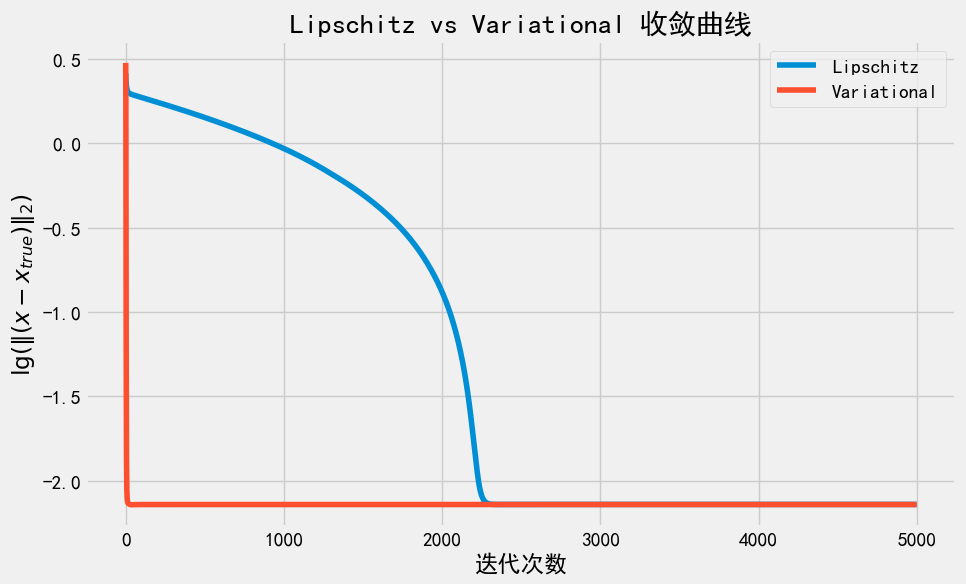

In [131]:
# 绘制收敛曲线
plt.figure(figsize=(10, 6))
plt.plot(error_Lipschitz, label='Lipschitz')
plt.plot(error_Variational, label='Variational')
plt.xlabel('迭代次数')
plt.ylabel(r'$\lg(\|(x - x_{true})\|_2)$')
plt.title('Lipschitz vs Variational 收敛曲线')
plt.legend()
# plt.grid()
plt.show()
